In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(themis)
library(janitor)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Preparing Data

In [2]:
players_data_raw <- read_csv("data/players.csv")
sessions_data_raw <- read_csv("data/sessions.csv")
players_data_raw
sessions_data_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:
players_data <- players_data_raw |>
                    drop_na() |>
                    rename(hashed_email = hashedEmail,
                            age = Age)

sessions_data <- sessions_data_raw |>
                    drop_na() |>
                    rename(hashed_email = hashedEmail) |>
                    mutate(across(c(start_time, end_time), dmy_hm),
                           session_duration = as.duration(end_time - start_time))
players_data
sessions_data

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


hashed_email,start_time,end_time,original_start_time,original_end_time,session_duration
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<Duration>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,720s (~12 minutes)
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,780s (~13 minutes)
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,1380s (~23 minutes)
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12,1260s (~21 minutes)
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12,420s (~7 minutes)
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12,1140s (~19 minutes)


## Average Hours Played by ...

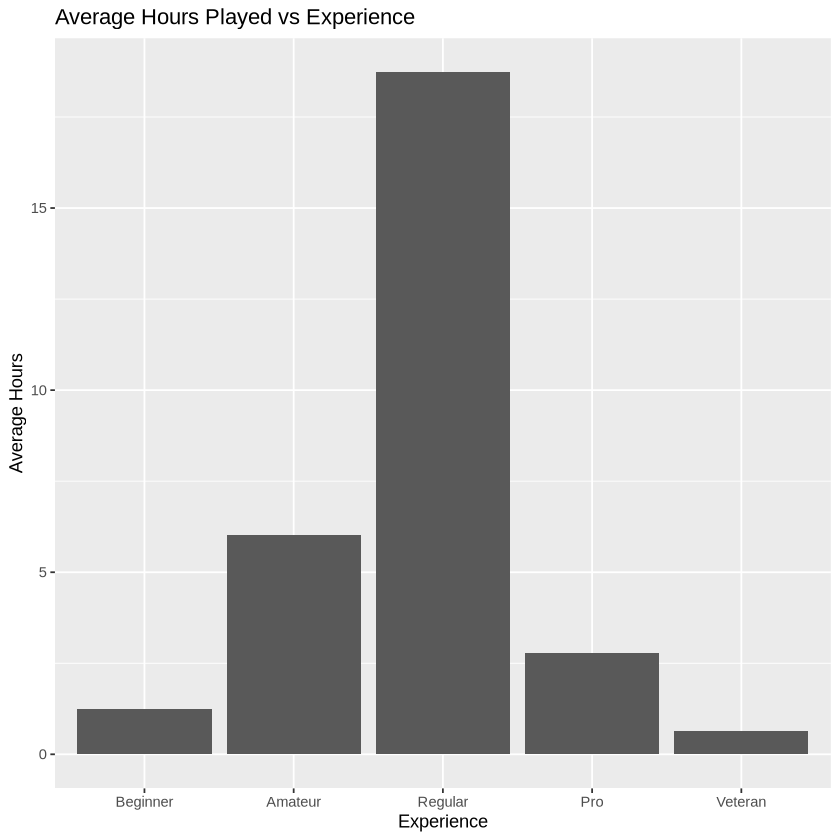

In [4]:
players_data |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))) |>
    group_by(experience) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = experience, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        ggtitle("Average Hours Played vs Experience") +
        xlab("Experience") +
        ylab("Average Hours")

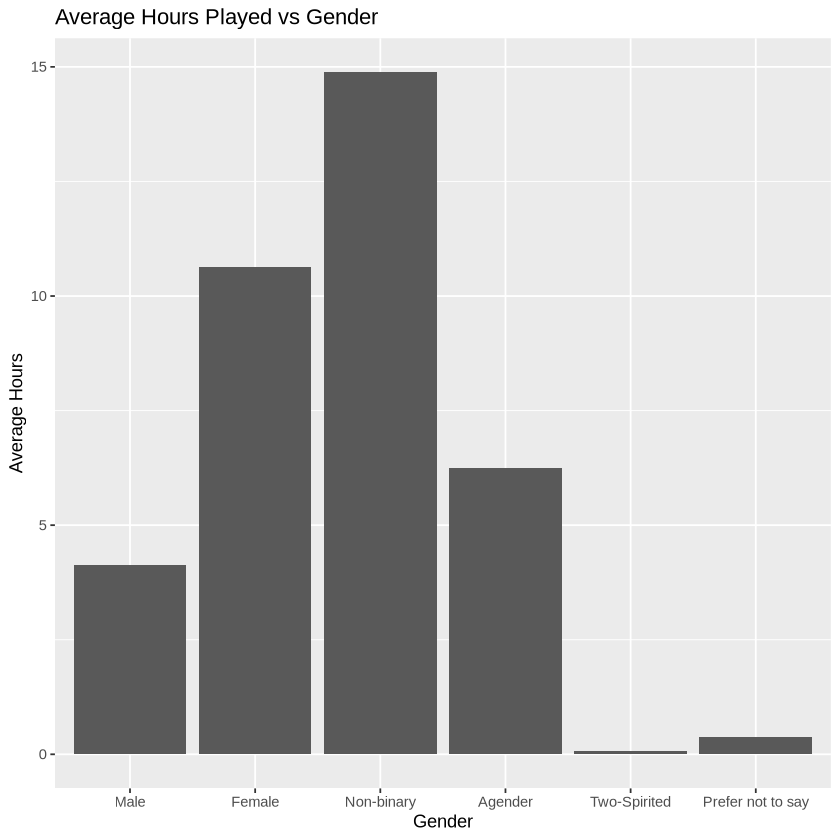

In [5]:
players_data |>
    mutate(gender = factor(gender, levels = c("Male", "Female", "Non-binary", "Agender", "Two-Spirited", "Prefer not to say"))) |>
    group_by(gender) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = gender, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        ggtitle("Average Hours Played vs Gender") +
        xlab("Gender") +
        ylab("Average Hours")

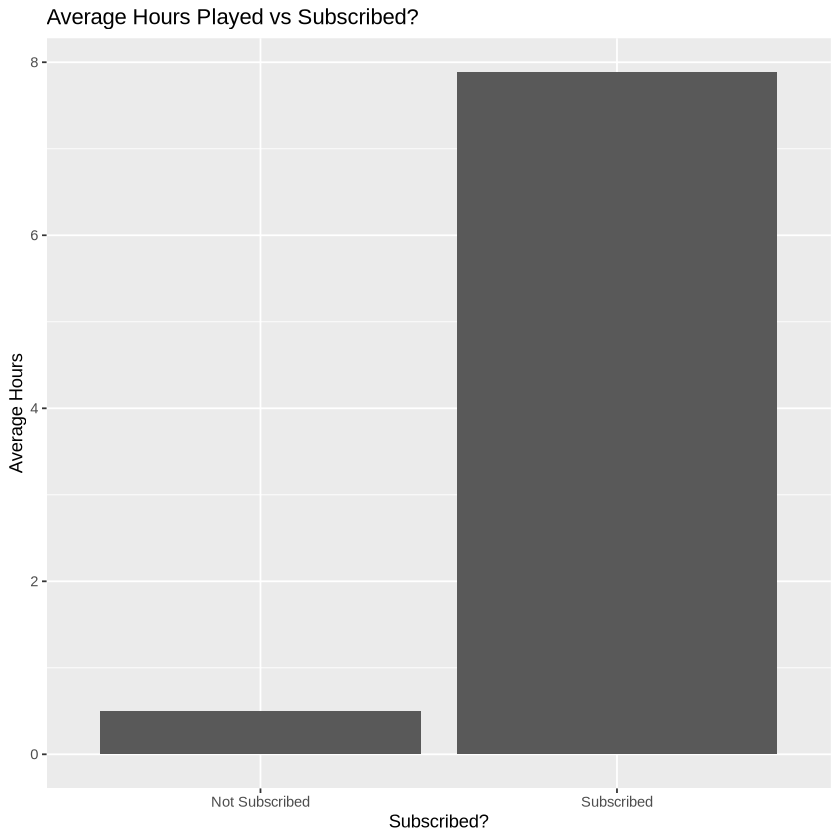

In [6]:
players_data |>
    group_by(subscribe) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        ggtitle("Average Hours Played vs Subscribed?") +
        xlab("Subscribed?") +
        ylab("Average Hours") +
        scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed"))

Warning message:
“`position_stack()` requires non-overlapping x intervals.”


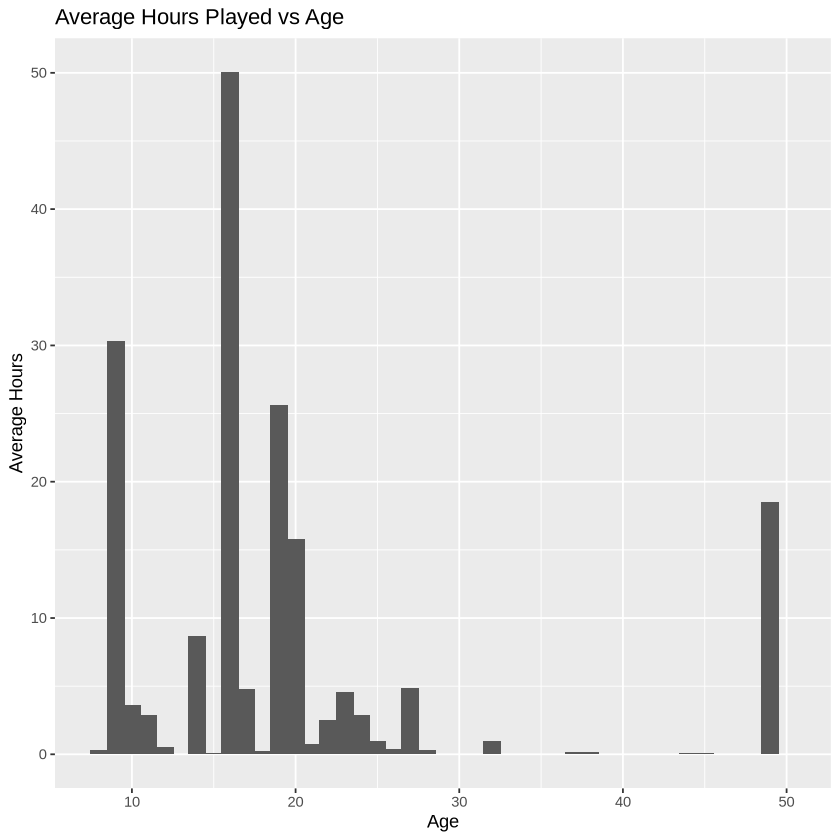

In [7]:
players_data |>
    group_by(age) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = age, y = avg_hrs)) +
        geom_bar(stat = "identity", width = 1.1) +
        ggtitle("Average Hours Played vs Age") +
        xlab("Age") +
        ylab("Average Hours")

## Number of logins by ...

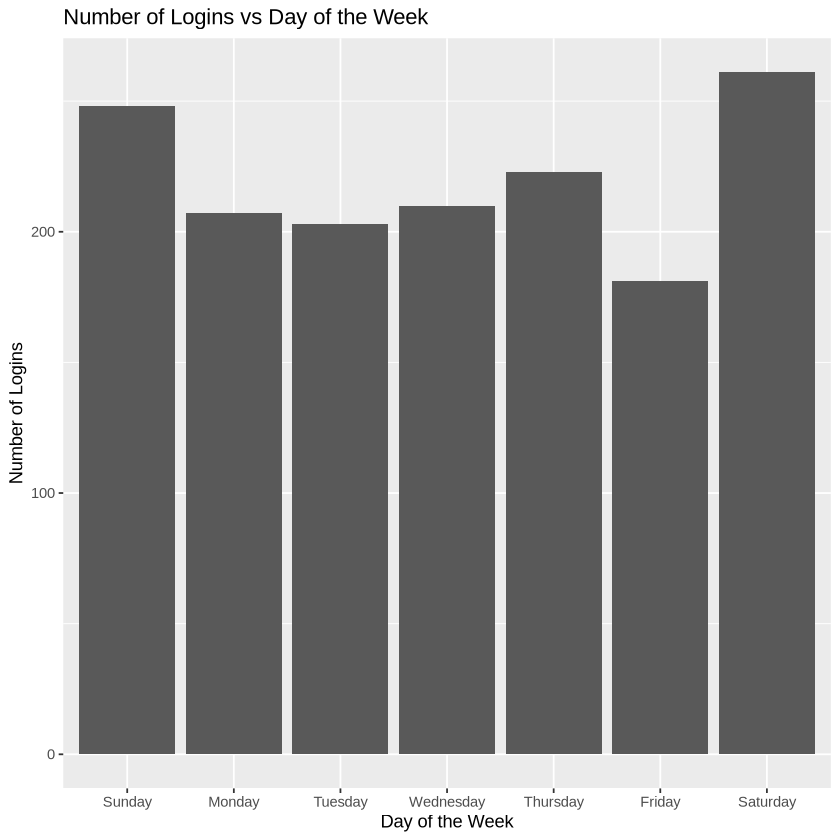

In [8]:
sessions_data |>
    mutate(day_of_week = weekdays(start_time), day_of_week = factor(day_of_week, levels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))) |>
    group_by(day_of_week) |>
    summarize(count = n()) |>
    ggplot(aes(x = day_of_week, y = count)) +
        geom_bar(stat = "identity") +
        ggtitle("Number of Logins vs Day of the Week") +
        xlab("Day of the Week") +
        ylab("Number of Logins")

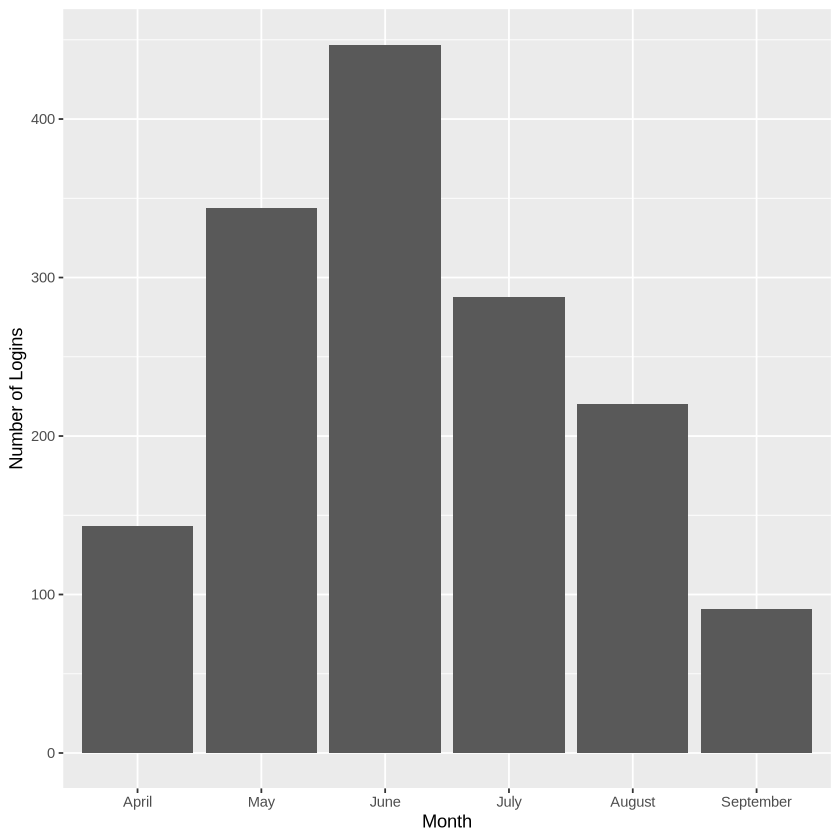

In [9]:
sessions_data |>
    mutate(month = factor(months(start_time), levels = month.name)) |>
    group_by(month) |>
    summarize(count = n()) |>
    ggplot(aes(x = month, y = count)) +
        geom_bar(stat = "identity") +
        xlab("Month") +
        ylab("Number of Logins")

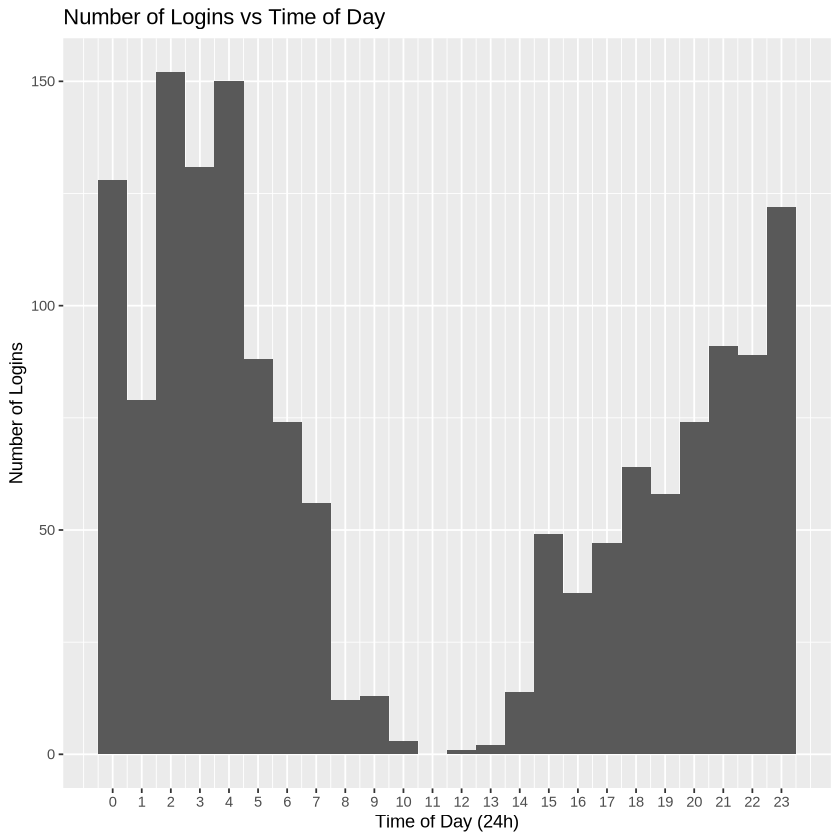

In [10]:
sessions_data |>
    mutate(hour = hour(start_time)) |>
    ggplot(aes(x = hour)) +
        geom_histogram(binwidth = 1) +
        ggtitle("Number of Logins vs Time of Day") +
        xlab("Time of Day (24h)") +
        ylab("Number of Logins") +
        scale_x_continuous(breaks = seq(0, 23, by = 1))

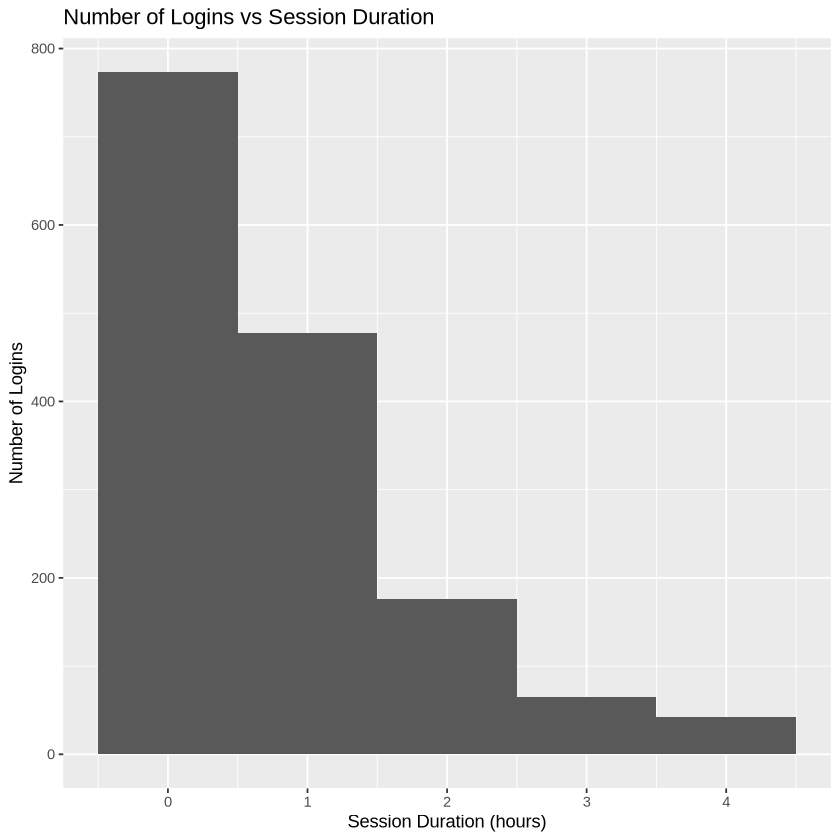

In [11]:
sessions_data |>
    ggplot(aes(x = as.numeric(session_duration, units = "hours"))) +
        geom_histogram(binwidth = 1) +
        ggtitle("Number of Logins vs Session Duration") +
        xlab("Session Duration (hours)") +
        ylab("Number of Logins")

Warning message:
“Removed 11 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


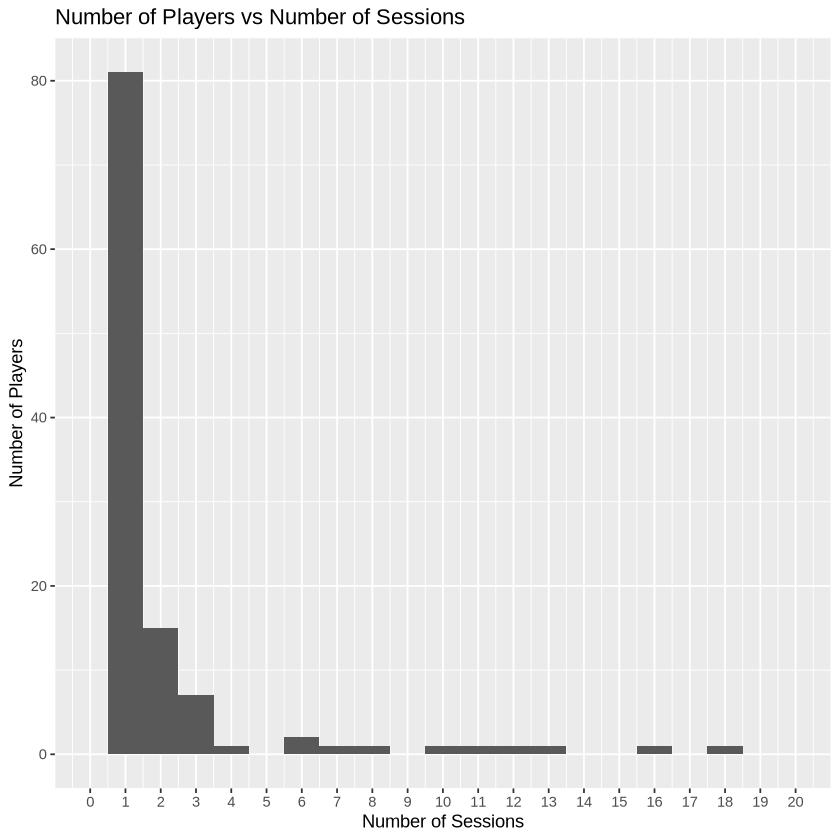

In [12]:
sessions_data |>
    group_by(hashed_email) |>
    summarize(num_sessions = n()) |>
    ggplot(aes(x = num_sessions)) +
        geom_histogram(binwidth = 1) +
        ggtitle("Number of Players vs Number of Sessions") +
        xlab("Number of Sessions") +
        ylab("Number of Players") +
        scale_x_continuous(limits = c(0, 20), breaks = seq(0, 20, by = 1))

Somehow there are more players with playtime than the number of players that played?

## Subscriber Ratio by ...

`summarise()` has grouped output by 'subscribe'. You can override using the
`.groups` argument.


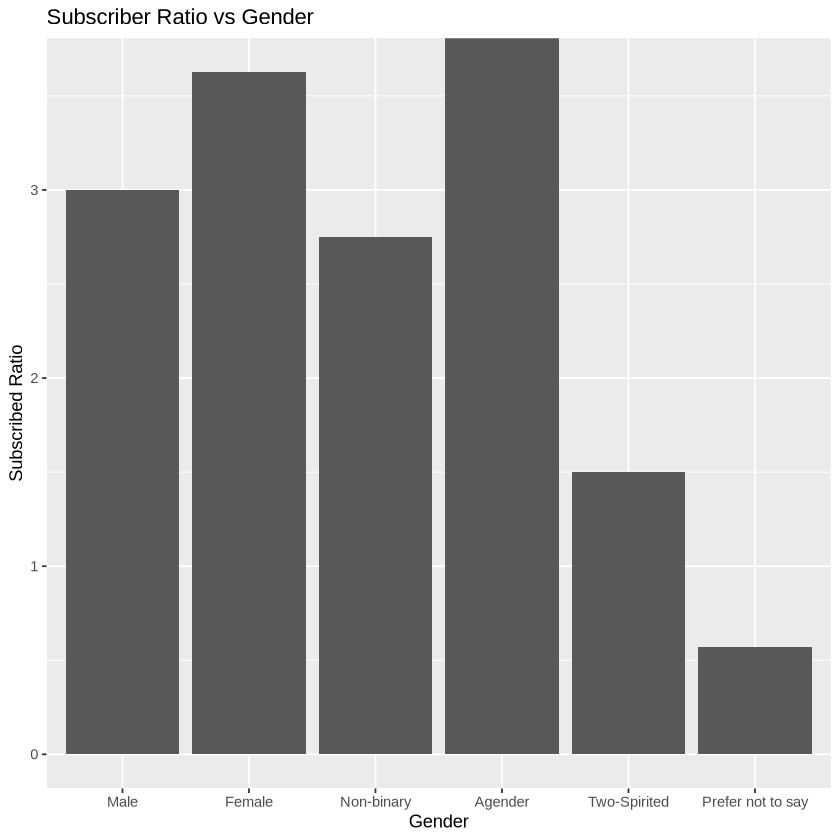

In [13]:
players_data |>
    group_by(subscribe, gender) |>
    summarize(count = n()) |>
    pivot_wider(names_from = subscribe, values_from = count, values_fill = list(count = 0)) |>
    mutate(sub_ratio = `TRUE` / `FALSE`, gender = factor(gender, levels = c("Male", "Female", "Non-binary", "Agender", "Two-Spirited", "Prefer not to say"))) |>
    select(gender, sub_ratio) |>
    ggplot(aes(x = gender, y = sub_ratio)) +
        geom_bar(stat = "identity") +
        ggtitle("Subscriber Ratio vs Gender") +
        xlab("Gender") +
        ylab("Subscribed Ratio") +
        scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed"))

`summarise()` has grouped output by 'subscribe'. You can override using the
`.groups` argument.


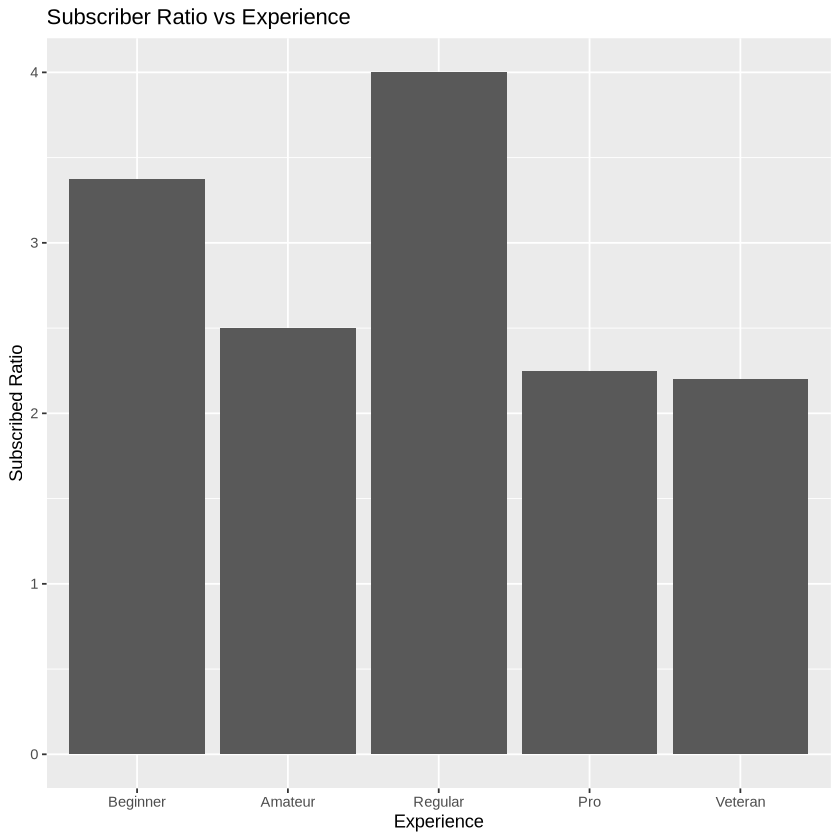

In [14]:
players_data |>
    group_by(subscribe, experience) |>
    summarize(count = n()) |>
    pivot_wider(names_from = subscribe, values_from = count, values_fill = list(count = 0)) |>
    mutate(sub_ratio = `TRUE` / `FALSE`, experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))) |>
    select(experience, sub_ratio) |>
    ggplot(aes(x = experience, y = sub_ratio)) +
        geom_bar(stat = "identity") +
        ggtitle("Subscriber Ratio vs Experience") +
        xlab("Experience") +
        ylab("Subscribed Ratio") +
        scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed"))

## Classification Model for Subscribers

In [15]:
players_data_avg_sess <- sessions_data |>
                            select(hashed_email, session_duration) |>
                            group_by(hashed_email) |>
                            summarize(avg_session_duration = mean(session_duration)) |>
                            inner_join(players_data, by = "hashed_email") |>
                            mutate(experience = as_factor(experience) |>
                                                    fct_relevel("Beginner", "Amateur", "Regular", "Pro", "Veteran") |>
                                                    as.numeric(),
                                  subscribe = as_factor(subscribe)) |>
                            pivot_wider(names_from = gender, values_from = gender, values_fn = length, values_fill = 0) |>
                            clean_names()

players_data_avg_sess_doubled <- rbind(players_data_avg_sess, players_data_avg_sess)
players_data_avg_sess_doubled

hashed_email,avg_session_duration,experience,subscribe,played_hours,name,age,male,female,non_binary,two_spirited,prefer_not_to_say,agender
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,3180,3,TRUE,1.5,Isaac,20,1,0,0,0,0,0
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1800,4,FALSE,0.4,Lyra,21,1,0,0,0,0,0
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,660,1,TRUE,0.1,Osiris,17,1,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,928.0645,2,TRUE,56.1,Dana,23,1,0,0,0,0,0
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,540.0000,2,TRUE,0.1,Fatima,17,1,0,0,0,0,0
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,4320.0000,1,TRUE,1.1,Caden,20,1,0,0,0,0,0


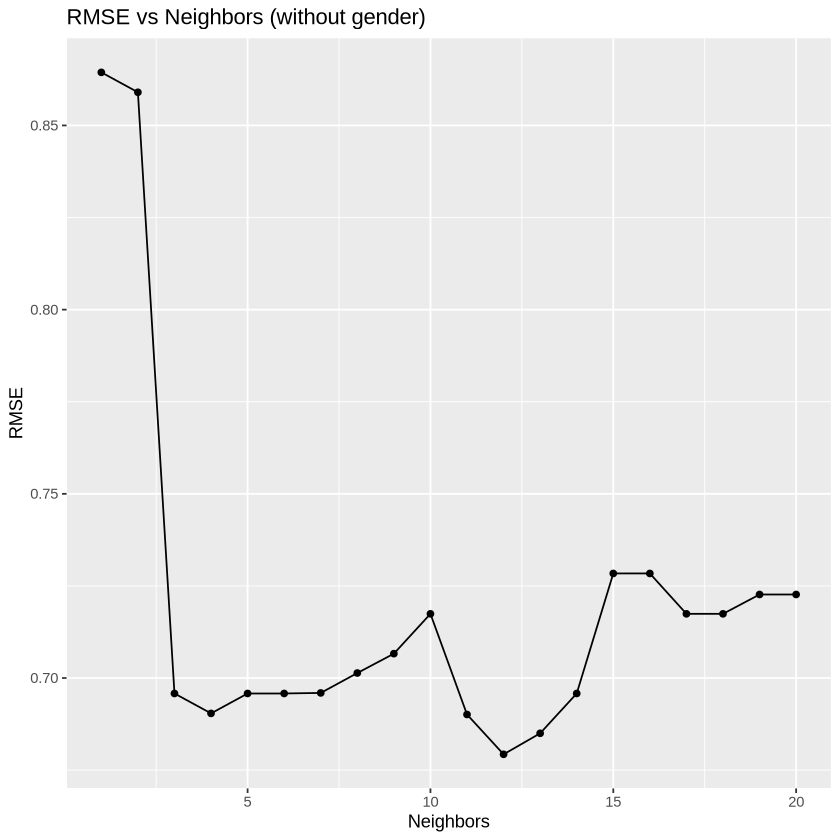

In [27]:
set.seed(0)

players_data_avg_sess_split <- players_data_avg_sess_doubled |>
                                initial_split(prop = 0.75)

players_data_avg_sess_training <- training(players_data_avg_sess_split)
players_data_avg_sess_testing <- testing(players_data_avg_sess_split)

subscribers_vfold <- vfold_cv(players_data_avg_sess_training, v = 5, strata = subscribe)

k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

subscribers_recipe <- recipe(subscribe ~ avg_session_duration + experience + played_hours + age + male + female + non_binary + two_spirited + prefer_not_to_say + agender, data = players_data_avg_sess_training) |>
                                step_rm(agender) |>
                                step_normalize(all_predictors())

subscribers_results <- workflow() |>
                        add_recipe(subscribers_recipe) |>
                        add_model(knn_spec) |>
                        tune_grid(resamples = subscribers_vfold, grid = k_values) |>
                        collect_metrics() |>
                        filter(.metric == "accuracy")

subscriber_results_plot <- subscribers_results |>
                                ggplot(aes(x = neighbors, y = mean)) +
                                    geom_point() +
                                    geom_line() +
                                    ggtitle("RMSE vs Neighbors (without gender)") +
                                    xlab("Neighbors") +
                                    ylab("RMSE")

subscriber_results_plot

In [28]:
best_k <- subscribers_results |>
                    arrange(desc(mean)) |>
                    slice(1) |>
                    pull(neighbors)

best_knn_spec <- nearest_neighbor(weight = "rectangular", neighbors = best_k) |>
                            set_engine("kknn") |>
                            set_mode("classification")

subscriber_fit <- workflow() |>
                    add_recipe(subscribers_recipe) |>
                    add_model(best_knn_spec) |>
                    fit(data = players_data_avg_sess_training)

In [29]:
subscribers_predictions <- predict(subscriber_fit, players_data_avg_sess_testing) |>
                                bind_cols(players_data_avg_sess_testing)

subscribers_accuracy <- subscribers_predictions |>
                            metrics(truth = subscribe, estimate = .pred_class) |>
                            filter(.metric == "accuracy") |>
                            pull(.estimate)

subscribers_precision <- subscribers_predictions |>
                            precision(truth = subscribe, estimate = .pred_class, event_level = "second") |>
                            pull(.estimate)

subscribers_recall <- subscribers_predictions |>
                            recall(truth = subscribe, estimate = .pred_class, event_level = "second") |>
                            pull(.estimate)

subscribers_conf_mat <- subscribers_predictions |>
                            conf_mat(truth = subscribe, estimate = .pred_class)

cat("Accuracy: ", subscribers_accuracy, "\n")
cat("Precision: ", subscribers_precision, "\n")
cat("Recall: ", subscribers_recall, "\n")
subscribers_conf_mat

Accuracy:  0.9032258 
Precision:  0.9555556 
Recall:  0.9148936 


          Truth
Prediction FALSE TRUE
     FALSE    13    4
     TRUE      2   43